In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
#jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

## Generate integration points
First we obtain coordinates of the integration points

In [236]:
#key = jax.random.key(42)
#B_key,C_key =jax.random.split(key)
#B_field = jax.random.normal(B_key,(512,512,256),)
#C_field = jax.random.normal(C_key,(512,512,256),)
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=128))
nside = 128
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls = obtain_vmap(theta,phi)


## Prepare C field and B field

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    #x = x
    #z = z
    #c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2#*(1-jnp.floor(c))


def C_uni(x:float,y:float,z:float,C0:float = 1.,):
    x = x+8.3
    z = z-0.06
    c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    return 1-jnp.floor(c)

R_obs = (8.3**2+0.006**2)**0.5

def C_sun(x:float,y:float,z:float,C0:float = 6.4e1,):
    z = jnp.abs(z)
    factor1 = 1-jnp.floor(z/jnp.max(jnp.array([z,1])))
    R = (x**2+y**2)**0.5
    C = C0*jnp.exp(-(R-R_obs)/8-z)
    
    return factor1*C

C_earth = C_page(-8.3,0,0.06)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))
C_uni_vmap = jax.vmap(lambda x,y,z:C_uni(x,y,z))
C_sun_vmap = jax.vmap(lambda x,y,z:C_sun(x,y,z))

'''def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):
    r = jnp.sqrt(x**2+y**2)
    phi = jnp.atan2(x,y)
    psi_r = psi_0+psi_1*jnp.log()
    return '''

'def B_page(x:float,y:float,z:float,B0:float = 4.,chi0:float = 0.43633232,psi0:float = 0.47123888,psi1:float=0.01570796,hphi:float=8,hchi:float=1):\n    r = jnp.sqrt(x**2+y**2)\n    phi = jnp.atan2(x,y)\n    psi_r = psi_0+psi_1*jnp.log()\n    return '

In [51]:
xs,step = jnp.linspace(-20,20,64,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,64,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,16,endpoint=False,retstep=True)
zs = zs + step*0.5

In [6]:
coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(64, 64, 16)

In [7]:
%%time
C_field = C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*6.4e1/C_earth
#C_field = C_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))#*6.4e1/C_earth
C_field = C_field.reshape((64,64,16))

CPU times: user 76.5 ms, sys: 3.7 ms, total: 80.2 ms
Wall time: 124 ms


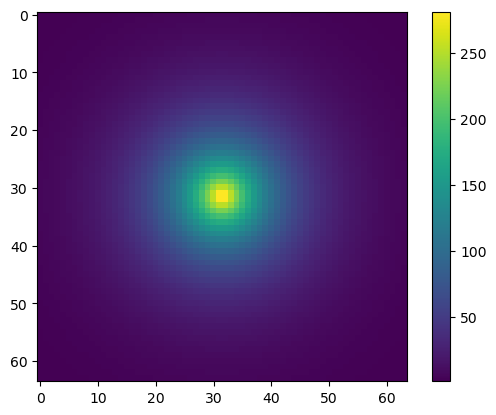

In [8]:
plt.imshow(C_field[:,:,8])
plt.colorbar()

In [289]:
dtype = np.float64  # 64-bit floating point

# Read the binary file
breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3)).reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3)).reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))*2

brnd[(coords[0]**2+coords[1]**2)>400]=0.

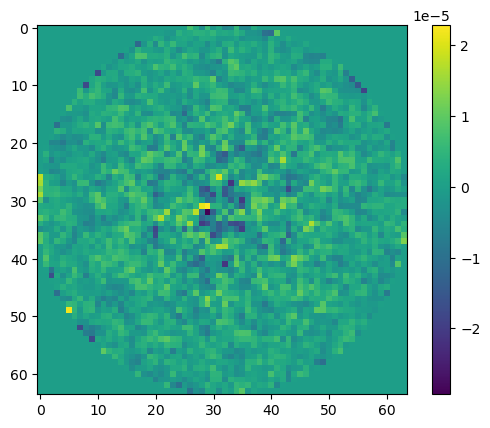

In [290]:
B_field = jnp.array(breg+brnd)*1.5
#B_field = B_field.reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))
#B_field[(coords[0]**2+coords[0]**2)**0.5<400]=0.
#B_field = jnp.ones_like(breg+brnd)*jnp.array([1.,0.,0.])*1e-6
#B_field = jnp.stack([C_field] * 3, axis=0).transpose(1,2,3,0)*1e-6*6
#C_field = jnp.ones_like(C_field)
B_field_square = (B_field**2).sum(axis=-1)
plt.imshow(B_field[:,:,8,2])
plt.colorbar()

## Calculate $B_{\rm trans}$

In [291]:
def obtain_nhat(x:float,y:float,z:float,obs_coord:tuple[float] = (-8.3,0.,0.006)):
    x_rel = x - obs_coord[0]
    y_rel = y - obs_coord[1]
    z_rel = z - obs_coord[2]
    r = (x_rel**2+y_rel**2+z_rel**2)**0.5
    return jnp.array([x_rel,y_rel,z_rel])/r

obtain_nhat_vamp = jax.vmap(lambda x,y,z:obtain_nhat(x,y,z))

In [292]:
nhats = obtain_nhat_vamp(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
nhats = nhats.reshape((64,64,16,3))

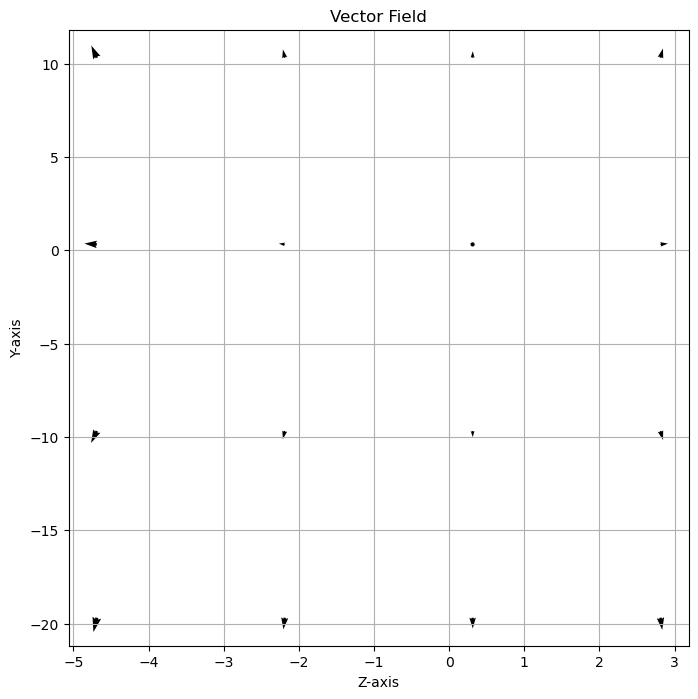

In [293]:
plt.figure(figsize=(8, 8))
plt.quiver(coords[2][128,::16,::4], coords[1][128,::16,::4], nhats[128,::16,::4,2], nhats[128,::16,::4,1], scale=1, scale_units='xy')
#plt.xlim(-2, 2)
#plt.ylim(-2, 2)
plt.xlabel('Z-axis')
plt.ylabel('Y-axis')
plt.title('Vector Field')
plt.grid()
plt.show()

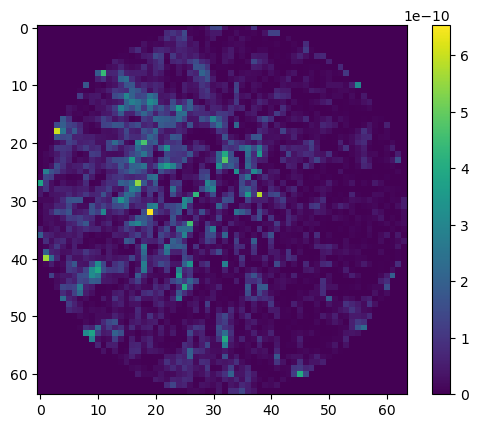

In [294]:
B_los_square = ((nhats*B_field)).sum(axis=-1)**2
plt.imshow(B_los_square[:,:,8])
plt.colorbar()

In [295]:
B_trans = (B_field_square-B_los_square)**0.5
#B_trans = C_field*1e-6*6

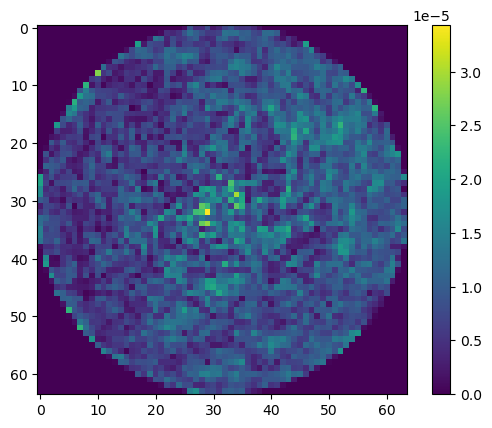

In [296]:
plt.imshow(B_trans[:,:,8])
plt.colorbar()
#B_trans.min()

## Calculate emissivity and interpolate

In [297]:
%%time
emiss = synax.sync_emiss_I(0.408,B_trans,C_field,spectral_index=3.)

CPU times: user 883 µs, sys: 509 µs, total: 1.39 ms
Wall time: 787 µs


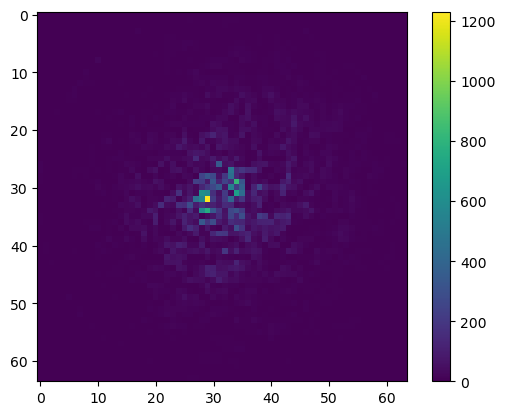

In [298]:
#emiss = emiss.at[100:110,10:20].set(1000)
plt.imshow(emiss[:,:,8])
plt.colorbar()

In [299]:
interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))

In [300]:
%%time
Sync_interp = interp_3d(poss)
Sync_int = Sync_interp.sum(axis=-1)*dls
Sync_int.min()

CPU times: user 24.6 ms, sys: 3.97 ms, total: 28.5 ms
Wall time: 26.7 ms


Array(23.353584, dtype=float32)

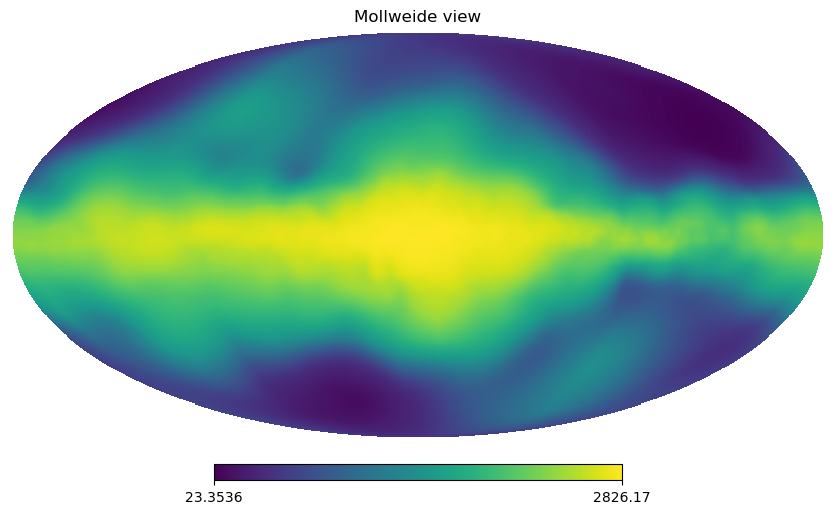

In [301]:
from copy import copy
hp.mollview(Sync_int,norm='hist')

## read haslam map, then reshape it

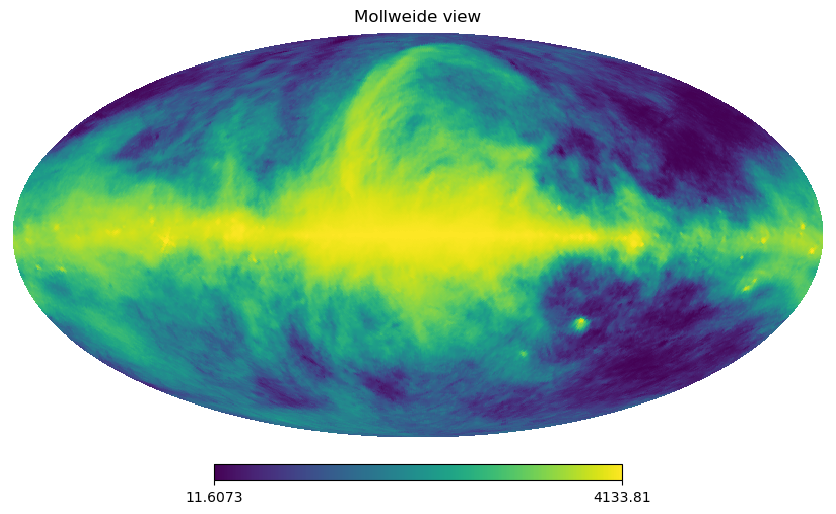

In [302]:
from astropy.io import fits
fits_image_filename = '../../SyncEmiss/obs/haslam408_dsds_Remazeilles2014.fits'

data = hp.read_map(fits_image_filename)

data = hp.reorder(data,r2n=True)

data = data.reshape((-1,16)).mean(axis=-1)

data = hp.reorder(data,n2r=True)

hp.mollview(data,norm='hist')

In [303]:
haslam_map = jnp.array(data)


def calc_map(B_field):
    emiss = synax.sync_emiss_I(0.408,B_field,C_field,spectral_index=3.)
    interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))
    Sync_interp = interp_3d(poss)
    Sync_int = Sync_interp.sum(axis=-1)*dls
    return (((Sync_int-haslam_map))**2).mean()

calc_grad = jax.value_and_grad(calc_map)

In [304]:
%%time
value,grad = calc_grad(B_trans)
grad.max()

CPU times: user 57.2 ms, sys: 23.3 ms, total: 80.4 ms
Wall time: 77.1 ms


Array(1.6958789e+08, dtype=float32)

In [320]:
from tqdm import tqdm
import optax

#B_opt = B_trans
solver = optax.yogi(1e-8)
#solver = optax.adam(learning_rate=1e-5)
opt_state = solver.init(B_opt)
loss = []
#mask = C_field/C_field.max()
mask = np.ones_like(B_opt)
mask[(coords[0]**2+coords[1]**2)>400]=0.
mask = jnp.array(mask)

progress_bar = tqdm(range(1000))
for i in progress_bar:
    value,grad = calc_grad(B_opt)
    loss.append(value)
    updates, opt_state = solver.update(grad, opt_state, B_opt)
    B_opt = optax.apply_updates(B_opt, updates)
    B_opt = jnp.where(B_opt < 1e-10, 1e-10, B_opt)*mask
    info = { 'loss': loss[-1]}
    
    # Update the postfix with the current info
    progress_bar.set_postfix(info)

100%|██████████| 1000/1000 [02:29<00:00,  6.70it/s, loss=424.75995]


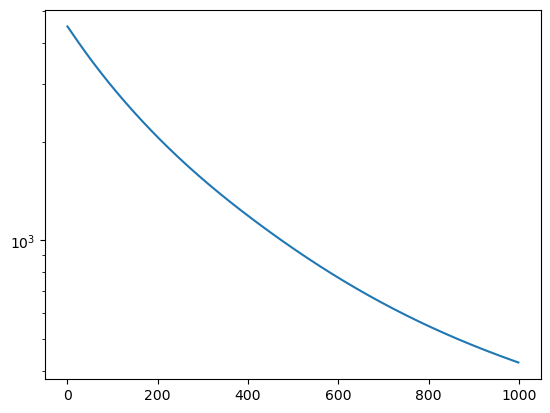

In [321]:
np.save('B_opt.npy',np.array(B_opt))
plt.semilogy(loss)
#print(loss)

In [322]:

def calc_sync(B_field):
    emiss = synax.sync_emiss_I(0.408,B_field,C_field,spectral_index=3.)
    interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,emiss,method='linear',extrap=True))
    Sync_interp = interp_3d(poss)
    Sync_int = Sync_interp.sum(axis=-1)*dls
    return Sync_int,emiss

Sync_map,emiss = calc_sync(B_opt)

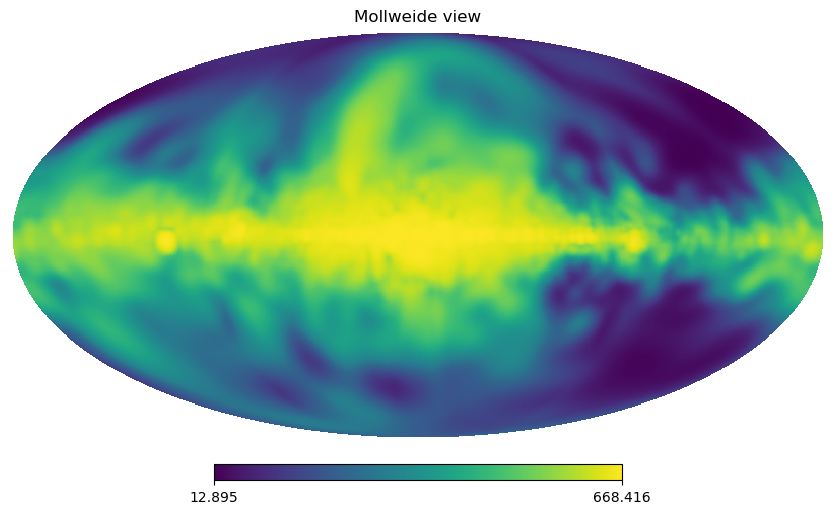

In [323]:
hp.mollview(Sync_map,norm='hist')

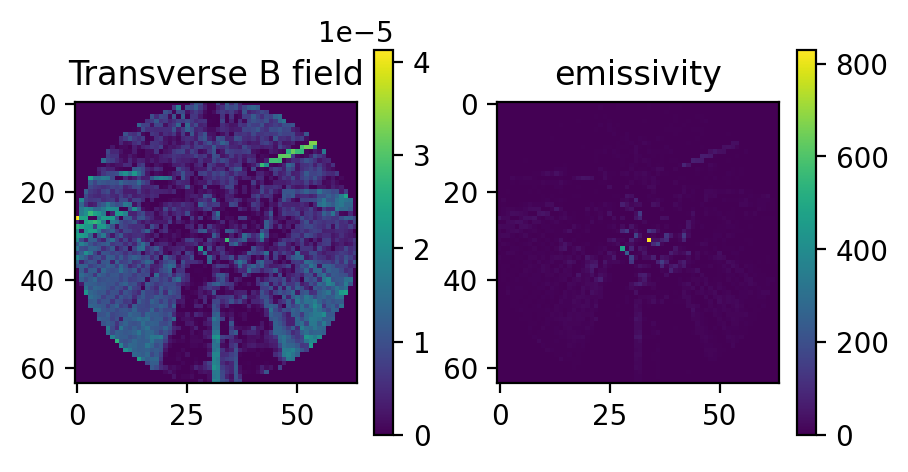

In [330]:
plt.figure(figsize=(5,2.5),dpi=200)

plt.subplot(121)
plt.imshow(((B_opt))[:,:,7])
plt.title('Transverse B field')
plt.colorbar()

plt.subplot(122)
plt.imshow(((emiss))[:,:,7])
plt.title('emissivity')
plt.colorbar()

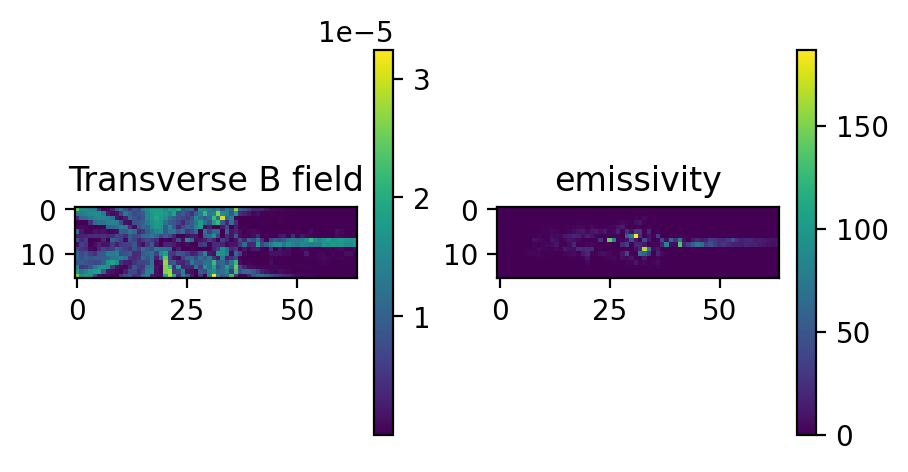

In [332]:
plt.figure(figsize=(5,2.5),dpi=200)

plt.subplot(121)
plt.imshow(((B_opt))[:,32,:].T)
plt.title('Transverse B field')
plt.colorbar()

plt.subplot(122)
plt.imshow(((emiss))[:,32,:].T)
plt.title('emissivity')
plt.colorbar()

In [25]:
10**-0.91

0.12302687708123815

In [56]:
const.electron_mass

9.1093837015e-31

In [84]:
const.e**3

4.1127393005630515e-57

In [65]:
const.electron_mass*const.speed_of_light**2

8.187105776823886e-14

In [77]:
jax.scipy.special.gamma(2./4+19/12.)

Array(1.0381436, dtype=float32, weak_type=True)

In [29]:
((B_field**2).sum(axis=-1)**0.5).min()

Array(1.999966e-06, dtype=float64)

In [215]:
hp.nside2npix(256)

786432

ModuleNotFoundError: No module named 'jaxopt'